# Exploring the Gen-3 Butler

<br>Owners: **Alex Drlica-Wagner** ([@kadrlica](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@kadrlica)), **Douglas Tucker** ([@douglasleetucker](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@douglasleetucker))
<br>Last Verified to Run: **2019-08-08**
<br>Verified Stack Release: **w_2020_03**

## Core Concepts

This notebook provides a first look at the structure and organization of a repo created with the Gen-3 Butler. The Gen-3 Butler is still under development, so this notebook is expected to be updated after the Gen-3 release.

1. Create a Gen-3 butler
2. Use the Gen-3 butler to explore the ci_hsc_gen3 data repo

## Learning Objectives:

This notebook lays out features of how the Gen-3 butler functions:

1. Explore a Gen-3 data repo

In [1]:
# Generic imports
import os
import pylab as plt

In [2]:
# Stack imports
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

To generate a data repo that was run with the Gen-3 butler, I used the HSC continuous integration sample. This was generated with code like this:

In [3]:
# Directory where the repo lives
repo='/project/shared/data/ci_hsc_gen3-w_2020_13'

You can poke around this directory a bit to see what outputs have been created.

In [4]:
# The base directory for the repo
!ls $repo

bin	 configs    DATA     pipelines	 resources   setup.cfg	ups
bin.src  COPYRIGHT  LICENSE  README.rst  SConstruct  tests


In [5]:
# The outputs are stored in the `DATA/shared/ci_hsc_output`
outdir=f'{repo}/DATA/shared/ci_hsc_output/20200403T11h48m46s'
!ls $outdir

assembleCoadd_metadata		deepCoadd_peak_schema
calexp				deepCoadd_psfMatchedWarp
calexpBackground		deepCoadd_ref
calibrate_metadata		deepCoadd_ref_schema
charImage_metadata		detection_metadata
deblend_metadata		forcedPhotCcd_metadata
deepCoadd			forcedPhotCoadd_metadata
deepCoadd_calexp		forced_src
deepCoadd_calexp_background	forced_src_schema
deepCoadd_deblendedFlux		icExp
deepCoadd_deblendedFlux_schema	icExpBackground
deepCoadd_det			icSrc
deepCoadd_det_schema		icSrc_schema
deepCoadd_directWarp		isr_metadata
deepCoadd_forced_src		makeWarpTask_metadata
deepCoadd_forced_src_schema	measure_metadata
deepCoadd_meas			mergeDetections_metadata
deepCoadd_measMatch		mergeMeasurements_metadata
deepCoadd_measMatchFull		postISRCCD
deepCoadd_meas_schema		src
deepCoadd_mergeDet		srcMatch
deepCoadd_mergeDet_schema	srcMatchFull
deepCoadd_nImage		src_schema


To create a butler you need to pass it a configuration file and a run name. The run name tells the butler where the place output files. More on Butler configuration can be found [here](https://pipelines.lsst.io/modules/lsst.daf.butler/configuring.html). By investigating the directory structue, we find that the 'collection' is `shared/ci_hsc_output`.

In [6]:
config = os.path.join(repo,'DATA','butler.yaml')
butler = dafButler.Butler(config=config,collections="shared/ci_hsc_output")

With the Gen-2 butler, there was no good way to investigate what data exist in a repo. To get around this, we all developed a habit of investigating the directory structure and file names to figure out what data existed.

In [7]:
!ls $outdir/20200403T11h48m46s/calexp

ls: cannot access /project/shared/data/ci_hsc_gen3-w_2020_13/DATA/shared/ci_hsc_output/20200403T11h48m46s/20200403T11h48m46s/calexp: No such file or directory


In [8]:
!ls $outdir/calexp/r/HSC-R

903334	903336	903338	903342	903344	903346


In [9]:
!ls $outdir/calexp/r/HSC-R/903338

calexp_r_HSC-R_903338_18_HSC_shared_ci_hsc_output_20200403T11h48m46s.fits
calexp_r_HSC-R_903338_25_HSC_shared_ci_hsc_output_20200403T11h48m46s.fits


Based on these filenames, we have enough to specify the dataId to pass to the butler...

In [10]:
dataId = {'visit':903338,'detector':25,'instrument':'HSC'}
calexp = butler.get('calexp', dataId=dataId)

(-0.5, 2047.5, -0.5, 4175.5)

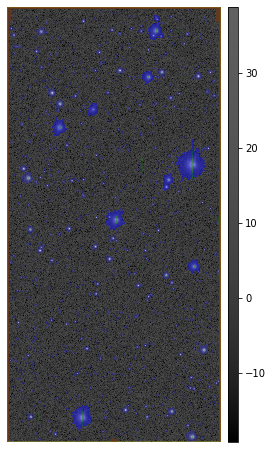

In [11]:
afwDisplay.setDefaultBackend('matplotlib') 
fig = plt.figure(figsize=(10,8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp)
plt.gca().axis('off')
# And if it wasn't sacrilege I would rotate this image...

## Gen-3 Butler

Ok, so how do we do this in Gen-3 land? Starting from scratch, we want to be able to get going *with only the path to the butler config*.

In [12]:
config = os.path.join(repo,'DATA','butler.yaml')

We would expect that we could just create a butler without specifying the collection (since we have no idea what collections exist at this point); however, this throws an exception (note: I think this is a bug, or at least an undesireable feature).

In [13]:
try: butler = dafButler.Butler(config=config)
except ValueError as e: print(e)

However, we can get around this by specifying an empty string for the collection.

In [14]:
butler = dafButler.Butler(config=config)

With the butler created, we can now access the registry

In [15]:
registry = butler.registry
#help(registry)

calib/hsc
skymaps
raw/hsc
shared/ci_hsc
masks/hsc
ref_cats
shared/ci_hsc_output/20200403T11h48m46s
shared/ci_hsc_output


The `registry` seems like a good tool for investigating a repo (more on the registry schema can be found [here](https://dmtn-073.lsst.io/)). For example, , which allows us to get a list of collectionswe can use the registry to get a list of all dataset types:

In [16]:
for c in registry.queryCollections():
    print(c)

In [17]:
for x in registry.queryDatasetTypes():
    print(x)

DatasetType(camera, {instrument, calibration_label}, Camera)
DatasetType(bfKernel, {instrument, calibration_label}, NumpyArray)
DatasetType(transmission_optics, {instrument, calibration_label}, TransmissionCurve)
DatasetType(transmission_sensor, {instrument, calibration_label, detector}, TransmissionCurve)
DatasetType(transmission_filter, {abstract_filter, instrument, calibration_label, physical_filter}, TransmissionCurve)
DatasetType(transmission_atmosphere, {instrument}, TransmissionCurve)
DatasetType(defects, {instrument, calibration_label, detector}, Defects)
DatasetType(deepCoadd_skyMap, {skymap}, SkyMap)
DatasetType(raw, {abstract_filter, instrument, detector, physical_filter, visit, exposure}, Exposure)
DatasetType(raw.image, {abstract_filter, instrument, detector, physical_filter, visit, exposure}, Image)
DatasetType(raw.mask, {abstract_filter, instrument, detector, physical_filter, visit, exposure}, Mask)
DatasetType(raw.variance, {abstract_filter, instrument, detector, physic

We suspect that this is all datasetTypes that the processing has *tried* to create during the processing. There may be intermediate products that were created during processing, but no longer exist.

It is now possible to get all `DatasetRef` (including `dataId`) for a specific `datasetType` in a specific collection with a query like the one that follows.

In [18]:
query = registry.queryDatasets(datasetType='src',collections=['shared/ci_hsc_output'])
for x in query:
    print(x)

src@{'instrument': 'HSC', 'detector': 100, 'visit': 904010} (id=3454)
src@{'instrument': 'HSC', 'detector': 17, 'visit': 903336} (id=3516)
src@{'instrument': 'HSC', 'detector': 6, 'visit': 903346} (id=3548)
src@{'instrument': 'HSC', 'detector': 23, 'visit': 903988} (id=3565)
src@{'instrument': 'HSC', 'detector': 10, 'visit': 904010} (id=3597)
src@{'instrument': 'HSC', 'detector': 12, 'visit': 903346} (id=3614)
src@{'instrument': 'HSC', 'detector': 18, 'visit': 903338} (id=3631)
src@{'instrument': 'HSC', 'detector': 16, 'visit': 903334} (id=3663)
src@{'instrument': 'HSC', 'detector': 100, 'visit': 903334} (id=3680)
src@{'instrument': 'HSC', 'detector': 11, 'visit': 903344} (id=3697)
src@{'instrument': 'HSC', 'detector': 4, 'visit': 903342} (id=3714)
src@{'instrument': 'HSC', 'detector': 1, 'visit': 904014} (id=3731)
src@{'instrument': 'HSC', 'detector': 10, 'visit': 903342} (id=3748)
src@{'instrument': 'HSC', 'detector': 22, 'visit': 903986} (id=3765)
src@{'instrument': 'HSC', 'detector

Ok, now that we know what collections exist (`shared/ci_hsc_output` in particular) we can set the collection for the butler and then we can query for one of the dataIds in our list above...

In [19]:
# Not sure this is the safest way...
butler.collections = 'shared/ci_hsc_output'
# Could instead create a new butler with the collection specified
#butler = dafButler.Butler(config=config,collections='shared/ci_hsc_output')

In [20]:
# The dataId that we found...
dataId = {'instrument': 'HSC', 'detector': 22, 'visit': 903334}

In [21]:
# Grab the calexp
calexp = butler.get('calexp', dataId=dataId)

In [22]:
# Grab the source table
src = butler.get('src',dataId=dataId)
src = src.copy(True)
src.asAstropy()

id,coord_ra,coord_dec,parent,calib_detected,calib_psf_candidate,calib_psf_used,calib_psf_reserved,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,ext_photometryKron_KronFlux_flag_badInitialCentroid_notAtMaximum,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_notAtMaximum,ext_shapeHSM_Hs

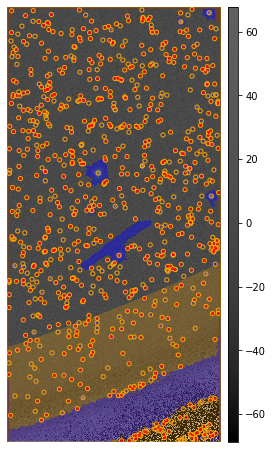

In [23]:
# And plot!
afwDisplay.setDefaultBackend('matplotlib') 
fig = plt.figure(figsize=(10,8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp)
plt.gca().axis('off')

with afw_display.Buffering():
    for s in src:
        afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
        afw_display.dot('o', s.getX(), s.getY(), size=20, ctype='orange') 

## Some Exploration

Below is a scratch space for playing with things...